# Electrocardiogaphy (EKG) signal processing

In this Jupyter notebook we will be analyzing EKG data previously acquired with 12-lead electrocardiogram at Chapman University and Shaoxing People's Hospital. The provided trial is part of a database containing 10,646 patients. Data were acquired consist ot 10-seg segments with a 500 Hz sampling rate, and the units are in 𝜇𝑉. The selected subject is an 18-year-old male. The complete dataset can be accessed [here](https://figshare.com/collections/ChapmanECG/4560497/2).

## Data analysis workflow
After the data has been acquired, it can be processed using specialized software. This software might be from the same manufacturer as the recording instrument. These software will often allow the data to be exported as a comma-separated value (i.e., `.CSV`) file type. Some manufacturers will also provide tools that allow for real-time access to the data while recording. 

## Import libraries
First, we will import the necessary libraries to read and analyze the downloaded [EKG data](./ekg_data.csv).

In [28]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, firwin, lfilter, freqz

## Import EKG data
First, we will import the EKG data from the [ekg_data.csv](ekg_data.csv) file with the `pandas` module.

In [11]:
# Settings
file_name = 'ekg_data.csv'
srate = 500 # Sampling rate [Hz]

# Import data and visualize 5 first rows
raw_data = pd.read_csv(file_name)
print(raw_data.head())


       I      II    III    aVR    aVL    aVF    V1      V2      V3      V4  \
0 -53.68 -112.24 -58.56  82.96   0.00 -87.84 -9.76 -102.48 -200.08 -224.48   
1 -58.56 -102.48 -43.92  82.96  -9.76 -73.20 -4.88 -107.36 -209.84 -234.24   
2 -58.56 -102.48 -43.92  82.96  -9.76 -73.20 -9.76 -117.12 -219.60 -248.88   
3 -63.44 -102.48 -39.04  82.96 -14.64 -73.20 -9.76 -122.00 -224.48 -244.00   
4 -63.44  -87.84 -24.40  78.08 -19.52 -58.56 -9.76 -122.00 -219.60 -244.00   

       V5      V6  
0 -141.52 -102.48  
1 -151.28 -117.12  
2 -151.28 -126.88  
3 -161.04 -126.88  
4 -151.28 -117.12  


## Visualize raw EKG
For this example we will be only using the the **Lead II** derivation since this is the most commonly used in clinical settings due to its aligment with the heart's electrical axis. Next, we will plot the raw data

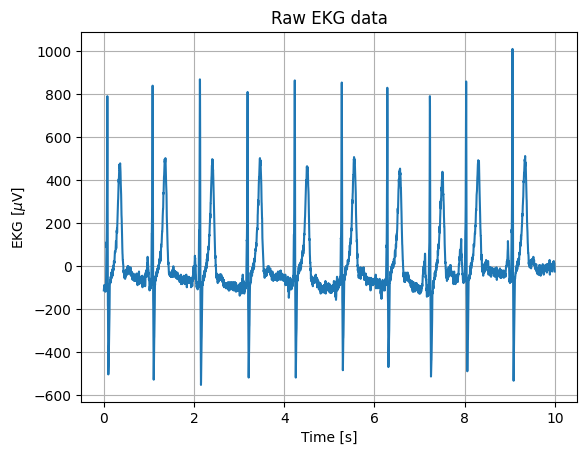

In [25]:
# Settings
time_mask = False    # Boolean to trim time for plot
time_start = 0      # Start time [s]
time_end = 2        # End time [s]

# Extract data
lead2_raw = raw_data['II'].to_numpy()               # Lead II data vector [uV]
time = np.arange(0, len(lead2_raw)/srate, 1/srate)  # Time vector [sec]

# Mask data for plotting 
if time_mask:
    time_mask_vector = (time >= time_start) & (time <= time_end)
    time = time[time_mask_vector]
    lead2_raw = lead2_raw[time_mask_vector]
else:
    time_plot = time
    ekg_plot = lead2_raw

# Plot raw data
plt.figure()
plt.plot(time, lead2_raw)
plt.xlabel('Time [s]')
plt.ylabel('EKG [$\mu$V]')
plt.title('Raw EKG data')
plt.grid()

## Frequency spectrum
First, we will compute the signal Fast Fourier Transform. This will reveal additional information about the possible noise sources that are affecting the signal.
Note that the majority of the EKG power is located between 0 and 40 Hz. 

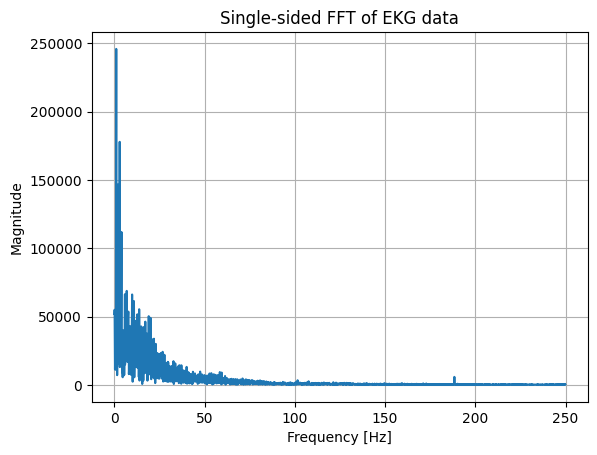

In [26]:
# Calculate the FFT
fft_result = np.fft.fft(lead2_raw)
fft_freq = np.fft.fftfreq(len(lead2_raw), d=1/srate)

# Take the single-sided FFT
single_sided_fft = np.abs(fft_result[:len(fft_result)//2])
single_sided_freq = fft_freq[:len(fft_freq)//2]

# Plot the single-sided FFT
plt.figure()
plt.plot(single_sided_freq, single_sided_fft)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Single-sided FFT of EKG data')
plt.grid()

## Filtering

### Notch-filtering
As you can see in the raw data plot, the signal is contaminated with some power-line noise. Design and apply a zero-phase FIR filter to eliminate this noise. Plot the power spectrum before and after the noise, as well as the time series to see the results.

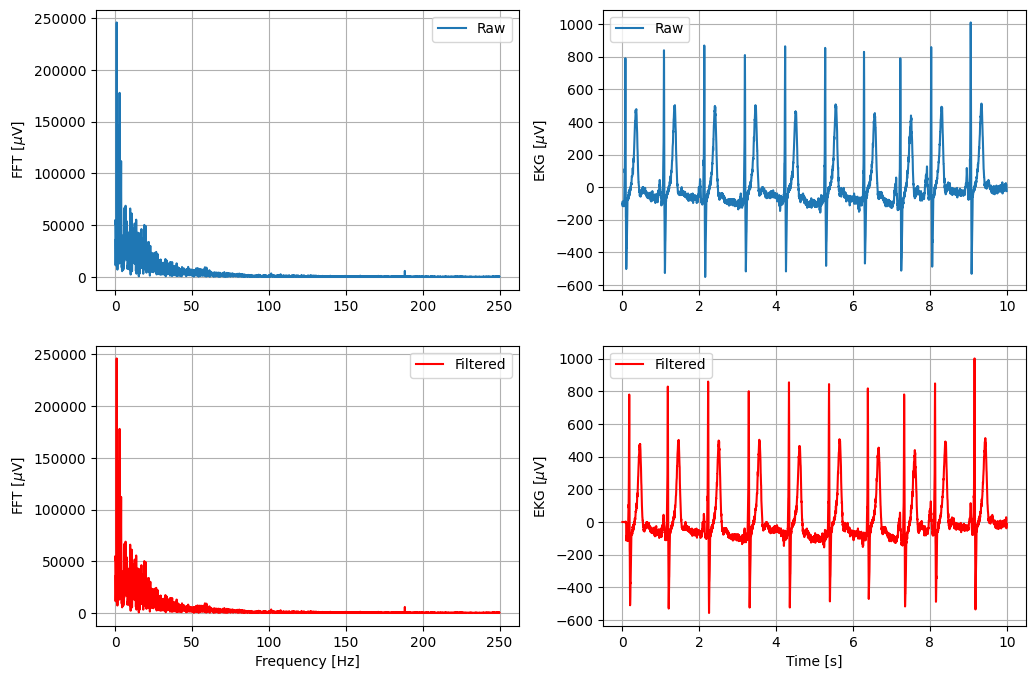

In [44]:
# Design zero-phase notch FIR filter
# -- Filter settings
fir_fc = [49, 51]               # Frequencies to be removed [Hz]
fir_order = 101                 # Order of the FIR filter [n]
fir_filter_type = "bandstop"    # Type of filter (lowpass, highpass, bandpass, bandstop)

# -- Design the FIR filter
fir_coefficients = firwin(fir_order, fir_fc, pass_zero=fir_filter_type, fs=srate)

# - Apply the FIR filter to the signal
lead2_notch = lfilter(fir_coefficients, 1.0, lead2_raw)

# Plot raw and filtered FFTs and time series
# -- Calculate the FFT of the filtered signal
fft_result_filtered = np.fft.fft(lead2_notch)
single_sided_fft_filtered = np.abs(fft_result_filtered[:len(fft_result_filtered)//2])

# -- Plot the raw and filtered FFTs
[fig, ax] = plt.subplots(2,2, figsize=(12,8))

ax[0,0].plot(single_sided_freq, single_sided_fft)
ax[0,0].set_ylabel('FFT [$\mu$V]')
ax[0,0].legend(['Raw'])
ax[0,0].grid()


ax[1,0].plot(single_sided_freq, single_sided_fft_filtered, color='r')
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].set_ylabel('FFT [$\mu$V]')
ax[1,0].legend(['Filtered'])
ax[1,0].grid()

# -- Plot the raw and filtered time series
ax[0,1].plot(time_plot, ekg_plot)
ax[0,1].set_ylabel('EKG [$\mu$V]')
ax[0,1].legend(['Raw'])
ax[0,1].grid()

ax[1,1].plot(time_plot, lead2_notch, color='r')
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('EKG [$\mu$V]')
ax[1,1].legend(['Filtered'])
ax[1,1].grid()

plt.show()